In [1]:
import numpy as np
# библиотека для вывода на консоль массивов
import matplotlib.pyplot
# убедитесь, что участки находятся внутри этой записной книжки, а не внешнего окна
%matplotlib inline
#plt.show() # Вместо %matplotlib inline в других средах, не notebook
from time import time, sleep #Для замера времени выполнения функций
from tqdm import tqdm #Для вывода прогресса вычисления функций
# glob помогает выбрать несколько файлов, используя шаблоны
import glob
# помощник для загрузки данных из файлов изображений PNG
import scipy.misc

In [2]:
# Загрузить mnist тренировочные данные в формате CSV 
training_data_file = open("MNIST_dataset/mnist_train.csv", 'r') # 'r' - открываем файл для чтения
training_data_list = training_data_file.readlines() # readlines() - читает все строки в файле в переменную training_data_list
training_data_file.close() # закрываем фаел csv

In [3]:
# Определение класса нейронной сети
class neuron_Net:
    
    
    # Инициализация весов нейронной сети
    def __init__(self, input_num, neuron_num, output_num, learningrate): #констр.(входной слой, скрытый слой, выходной слой)
                                                # МАТРИЦЫ ВЕСОВ
        # Задаем матрицы весов как случайное
        self.weights = np.random.normal(0.0, pow(input_num, -0.5), (neuron_num, input_num))
        self.weights_out = np.random.normal(0.0, pow(neuron_num, -0.5), (output_num, neuron_num))
        # Можно задать веса таким образом
        #self.weights = (numpy.random.rand(neuron_num, input_num) -0.5) 
        #self.weights_out = (numpy.random.rand(output_num, neuron_num) -0.5)

        # скорость обучения
        self.lr = learningrate
        
        pass

    
    # Обучение нейронной сети
    def train(self, inputs_list, targets_list): # принемает входной список данных,targets ответы
        # Преобразовать список входов и ответов в вертикальный массив. .T - транспонирование
        inputs_x = np.array(inputs_list, ndmin=2).T # матрица числа
        targets_Y = np.array(targets_list, ndmin=2).T # матрица ответов какое это число
        
                                        # ВЫЧИСЛЕНИЕ СИГНАЛОВ ПО СЛОЯМ
        # Вычислить сигналы в нейронах скрытого слоя. Взвешенная сумма.
        x1 = np.dot(self.weights, inputs_x) # dot - умножение матриц X = W*I = weights * inputs
        
        # вычислить сигналы, возникающие из скрытого слоя. сигмоида(Xhidden - сигнал скр.слоя)
        y1 = 1/(1+np.exp(-x1))
        
        # вычислить сигналы в окончательном выходном слое (матрица сигналов выходного слоя)
        x2 = np.dot(self.weights_out, y1) 
        # вычислить сигналы, исходящие из конечного выходного слоя. сигмоида(Xoutputs - сигнал вых.слоя)
        y2 = 1/(1+np.exp(-x2))
        
                                            # ВЫЧИСЛЕНИЕ ОШИБКИ ПО СЛОЯМ
        #  Ошибка выходного слоя E = -(цель - фактическое значение) 
        E = -(targets_Y - y2)
        # Ошибка скрытого слоя
        E_hidden = np.dot(self.weights_out.T, E) 
        
                                            # ОБНОВЛЕНИЕ ВЕСОВ ПО СЛОЯМ
        # Меняем веса исходящие из скрытого слоя по каждой связи
        self.weights_out -= self.lr * np.dot((E * y2 * (1.0 - y2)), np.transpose(y1))
        
        # Меняем веса исходящие из входного слоя по каждой связи
        self.weights -= self.lr * np.dot((E_hidden * y1 * (1.0 - y1)), np.transpose(inputs_x))
        
        pass

                                        # МЕТОД ПРОГОНА СВОИХ ЗНАЧЕНИЙ ПО СЕТИ
   # Метод прогона тестовых значений
    def query(self, inputs_list): # Принимает свой набор тестовых данных
        # Преобразовать список входов в вертикальный массив. 
        inputs_x = np.array(inputs_list, ndmin=2).T 
        
        # Вычислить сигналы в нейронах скрытого слоя. Взвешенная сумма.
        x1 = np.dot(self.weights, inputs_x) # dot - умножение матриц X = W*I = weights * inputs
        # Вычислить сигналы, выходящие из нейрона. Функция активации - сигмоида(x)
        y1 = 1/(1+np.exp(-x1))
        # Вычислить сигналы в нейронах выходного слоя. Взвешенная сумма.
        x2 = np.dot(self.weights_out, y1) 
        # вычислить сигналы, исходящие из конечного выходного слоя. Функция активации - сигмоида(x)
        y2 = 1/(1+np.exp(-x2))
        
        return y2                                   

In [4]:
                                        # ЗАДАЁМ ПАРАМЕТРЫ СЕТИ
# Количество входных данных, нейронов
data_input = 784
data_neuron = 220
data_output = 10

# Cкорость обучения
learningrate = 0.15

# Создать экземпляр нейронной сети
n = neuron_Net(data_input, data_neuron, data_output, learningrate)

In [5]:
                                                # ОБУЧЕНИЕ
# Зададим количество эпох
epochs = 3

start = time()
# Прогон по обучающей выборке
for e in range(epochs):
    # Пройдите все записи в наборе тренировочных данных    
    #for record in training_data_list:
    for i in tqdm(training_data_list, desc = str(e+1)): # tqdm - используем интерактив состояния прогресса вычисления
        # Получить входные данные числа
        all_values = i.split(',') # split(',') - раздел строку на символы где запятая "," символ разделения
        # Массив данных входа с масштабированием от 0,01 до 0,99
        inputs_x = (np.asfarray(all_values[1:])/ 255.0 * 0.99) + 0.01 # Игнорируем нулевой индекс, где целевое значение
        
        # Получить целевое значение Y, (ответ - какое это число)
        targets_Y = int(all_values[0])  # перевод символов в int, 0 элемент - целевое значение
        
        # создать целевые выходные значения (все 0.01, кроме нужной метки, которая равна 0.99)
        targets_Y = np.zeros(data_output) + 0.01
        
        # Получить целевое значение Y, (ответ - какое это число). all_values[0] - целевая метка для этой записи
        targets_Y[int(all_values[0])] = 0.99
            
        n.train(inputs_x, targets_Y) # наш метод train - обучение нейронной сети
        
        pass
    pass

time_out = time() - start
print("Время выполнения: ", time_out, " сек" )

3: 100%|████████████████████████████████████████████████████████████████████████| 60000/60000 [01:35<00:00, 627.15it/s]


Время выполнения:  287.62470269203186  сек


In [6]:
                                    # ТЕСТИРОВАНИЕ ОБУЧЕННОЙ СЕТИ
# Загрузить тестовый CSV-файл
test_data_file = open("MNIST_dataset/mnist_test.csv", 'r') # 'r' - открываем файл для чтения
test_data_list = test_data_file.readlines()  # readlines() - читает все строки в файле в переменную test_data_list
test_data_file.close() # закрываем файл csv

In [7]:
                                    # ПРОВЕРКА ЭФФЕКТИВНОСТИ НЕЙРОННОЙ СЕТИ
# Массив показателей эффективности сети, изначально пустой
efficiency = []

# Прогон по всем записям в наборе тестовых данных
for i in test_data_list:
    # Получить входные данные числа 
    all_values = i.split(',') # split(',') - раздел строку на символы где запятая "," символ разделения
    # Правильный ответ, хранимый в нулевом индексе
    targets_Y = int(all_values[0])
    # Массив данных входа с масштабированием от 0,01 до 0,99
    inputs_x = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01 # Игнорируем нулевой индекс, где целевое значение

    # Запросить ответ у сети
    outputs_y = n.query(inputs_x) # Прогон по сети тестового значения из нашего файла
    # Индекс самого высокого значения на матрице выхода, соответствует метке числа
    label_y = np.argmax(outputs_y) # argmax возвращает индекс максимального элемента в выходном массиве
    
    # Добавить правильный или неправильный список
    if (label_y == targets_Y): # Если индекс макс. знач. на выходе = целевому значению (0 индекс массива данных)
        # Если ответ сети соответствует целевому значению, добавляем 1 в конец массива показателей эффективности
        efficiency.append(1)
    else:
        # Если ответ сети не соответствует целевому значению, добавляем 0 в конец массива показателей эффективности
        efficiency.append(0)
        
        pass
    
    pass

In [8]:
# Вычислить оценку производительности. Доля правильных ответов
efficiency_map = np.asarray(efficiency) # asarray - преобразование списка в массив 

print ('Производительность = ', (efficiency_map.sum() / efficiency_map.size)*100, '%') # Среднее арифметическое 

Производительность =  97.09 %


In [57]:
                                # СОБСТВЕННЫЙ НАБОР ИЗОБРАЖЕНИЙ ДЛЯ ТЕСТА
my_dataset = [] # Для хранения данных и целевых значений 

# Загрузить данные изображения в формате PNG, как установить тестовые данные
for image_file in glob.glob('my_image/_my_?.png'): # проход по файлам изобр. в папке my_images
    #glob - из библиотеки glob, помогает выбрать сразу несколько файлов из папки
    
    # Метка имени числа
    label_y = int(image_file[-5:-4]) # хранит число в файле ?.png, -5 это ответ какое число '?'
    # от -5 до -4 это будет символ '?', т.е метка числа
    
    # Загрузить данные изображения из png файлов в массив
    print ('Имя файла: ', image_file) # вывод пути и имени открытого файла
    
    image_list = scipy.misc.imread(image_file, flatten=True) #“flatten=True” (“выровнять=True) ”- превращает
    #изображения в простой массив чисел с плавающей запятой
    
    # Изменить формат из 28x28 в список 784 значений, инвертировать значения
    image_data  = 255.0 - image_list.reshape(784) #преобразует массив из квадрата 28x28 в длинный список значений
    #вычитание значений массива из 255.0. т.к обычно '0' означает черное, а '255' означает белое, но набор данных MNIST  
    #имеет инверсные значения, поэтому мы должны их перевернуть
    
    # Вносим данные шкалу с диапазоном от 0 до 1
    image_data = (image_data / 255.0 ) # массив данных входа с масштабированием от 0 до 1   
    
    # Добавить метку числа и данные изображения к общему набору данных
    my_data = np.append(label_y, image_data)
    my_dataset.append(my_data) 
    
    pass

Имя файла:  my_image\_my_0.png


D:\Anaconda_3\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


Имя файла:  my_image\_my_1.png
Имя файла:  my_image\_my_2.png
Имя файла:  my_image\_my_3.png
Имя файла:  my_image\_my_4.png
Имя файла:  my_image\_my_5.png
Имя файла:  my_image\_my_6.png
Имя файла:  my_image\_my_7.png
Имя файла:  my_image\_my_8.png


[[  6.66671197e-01]
 [  2.56659427e-03]
 [  9.32429328e-03]
 [  6.77700446e-05]
 [  1.92683835e-03]
 [  2.02324562e-03]
 [  3.13702331e-03]
 [  8.52300221e-03]
 [  2.36677373e-04]
 [  4.81128855e-03]]
Минимальное значение:  6.77700445779e-05
Максимальное значение:  0.666671197018

Целевое значение:  0
Угадал!!! :-)))


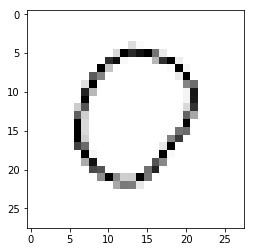

In [60]:
                                # ПРОВЕРКА СЕТИ НА СОБСТВЕННЫХ ДАННЫХ ИЗОБРАЖЕНИЙ

# запись для тестирования
room_choices = 0

# Изображение участка
matplotlib.pyplot.imshow(my_dataset[room_choices][1:].reshape(28,28), cmap='Greys', interpolation='None')
# my_dataset- наш собственный набор тестовых данных

# Правильный ответ в нулевом столбце
correct_label = my_dataset[room_choices][0] # в строках номер файла из папки собственных данных, 0 толбец - ответ какое число

# Входные значения
input_x = my_dataset[room_choices][1:] # значение числа без ответа

# Запросить сеть
output_y = n.query(input_x) # прогоняем тестовую выборку по сети
print (output_y) # вывод по выходу сети

print('Минимальное значение: ', np.min(output_y)) # вывод мин знач элемента на выходе
print('Максимальное значение: ', np.max(output_y)) # вывод макс знач элемента на выходе

# Индекс самого высокого значения на выходе сети, соответствует метке
number = np.argmax(output_y)
print('\nЦелевое значение: ', number)

# Вывод правильный или неправильный ответ
if (number == correct_label): # если макс знач на выходе label = ответу (0 индекс из массива) correct_label
    print ('Угадал!!! :-)))') 
else:
    print ('Не угадал! :-(((') 
    
    pass